## Setup

In [5]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
from google.colab import drive
drive.mount('/content/drive/')
project_root_dir = '/content/drive/My Drive/CS_229_project/'

Mounted at /content/drive/


In [29]:
aqi_dir = os.path.join(project_root_dir, 'aqi_data', 'final_data')
experiments_dir = os.path.join(project_root_dir, 'experiments')
img_dir = os.path.join(project_root_dir, 'img_data')

# Simple pixel-level softmax

## Preliminaries

In [8]:
# Load training, validation, and test X datasets
# These are created in the move_images_to_folders.ipynb
train = np.load(os.path.join(experiments_dir, 'train.npz'))
valid = np.load(os.path.join(experiments_dir, 'valid.npz'))
test = np.load(os.path.join(experiments_dir, 'test.npz'))

In [9]:
train['x'].shape

(3333, 224, 224, 3)

In [10]:
# Create class weights based off frequency
from collections import Counter
item_ct = Counter(train['y'])
max_ct = float(max(item_ct.values()))
class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}
class_wts

{0: 1.0, 1: 1.800990099009901, 2: 3.609126984126984}

In [11]:
# Center and scale training and validation X
x_mean = train['x'].mean(axis = 0, keepdims = True)
x_std = train['x'].std(axis = 0, keepdims = True) + 1e-7
x_train = (train['x'] - x_mean) / x_std
x_valid = (valid['x'] - x_mean) / x_std

In [12]:
# Flatten the data for modeling
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_valid_flattened = x_valid.reshape(x_valid.shape[0], -1)

In [13]:
from gc import collect
del x_train, x_valid
collect()

124

In [14]:
# Group the data into X and Y
x_all = np.concatenate((x_train_flattened, x_valid_flattened))
y_all = np.concatenate((train['y'], valid['y']))

In [15]:
collect()
del x_train_flattened, x_valid_flattened

## SGD Classifier

### Tuned SVM with optimal SVM parameters

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42, loss = 'hinge', class_weight = class_wts, alpha = 1, penalty = 'l2', verbose = False)

In [17]:
sgd_clf.fit(x_all, y_all)

SGDClassifier(alpha=1, average=False,
              class_weight={0: 1.0, 1: 1.800990099009901, 2: 3.609126984126984},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=False, warm_start=False)

### SVM with a Radial Basis Function Kernel

In [ ]:
from sklearn.svm import SVC
svc_clf = SVC(random_state = 42, class_weight = class_wts, C = 1, verbose = True)

In [ ]:
# Fit the model and also predict on the test set
# Note, this will take upwards of an hour to fit for a dataset
# with 4000 images
svc_clf.fit(x_all, y_all)

[LibSVM]

0.7072457245724573

In [ ]:
# Test accuracy
test_preds = svc_clf.predict(x_test_flattened)
test_accuracy = accuracy_score(test['y'], test_preds)
test_accuracy

0.6453645364536453

In [ ]:
# Training accuracy
train_preds = svc_clf.predict(x_all)
train_accuracy = accuracy_score(y_all, train_preds)
train_accuracy

0.7072457245724573

### Bias Variance Curve
Create a bias variance curve by fitting several models of various sizes and seeing the test and training accuracy

Things to try:

* Try getting more training examples
* Try a smaller set of features
* Try a larger set of features
* Run gradient descent for more iterations
* Try Newton's method
* Use a different value of lambda



In [ ]:
from collections import Counter
from gc import collect
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import log_loss
import seaborn as sns

In [ ]:
# Reset filepaths
train = np.load(os.path.join(experiments_dir, 'train.npz'))
valid = np.load(os.path.join(experiments_dir, 'valid.npz'))
test = np.load(os.path.join(experiments_dir, 'test.npz'))

In [ ]:
# Create the setup for the training set sizes
n_train = train['x'].shape[0]
n_valid = valid['x'].shape[0]
seq_train = np.linspace(100, n_train, dtype = int, num = 10)
seq_valid = np.linspace(100, n_valid, dtype = int, num = 10)
idx_train = [np.random.choice(n_train, size = i, replace = False) for i in seq_train]
idx_valid = [np.random.choice(n_valid, size = i, replace = False) for i in seq_valid]

In [ ]:
collect()
len(idx_valid[9])

1111

In [ ]:
# Iterate through all the training sizes fitting a model and reporting the accuracy
for i in range(0,len(idx_train)):
  # Load training, validation, and test X datasets
  item_ct = Counter(train['y'][idx_train[i]])
  max_ct = float(max(item_ct.values()))
  class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}

  # Center and scale training and validation X
  x_mean = train['x'][idx_train[i],:].mean(axis = 0, keepdims = True)
  x_std = train['x'][idx_train[i],:].std(axis = 0, keepdims = True) + 1e-7
  x_train = (train['x'][idx_train[i],:] - x_mean) / x_std
  x_valid = (valid['x'][idx_valid[i],:] - x_mean) / x_std
  x_train_flattened = x_train.reshape(x_train.shape[0], -1)
  x_valid_flattened = x_valid.reshape(x_valid.shape[0], -1)
  del x_train
  del x_valid
  collect()
  x_all = np.concatenate((x_train_flattened, x_valid_flattened))
  y_all = np.concatenate((train['y'][idx_train[i]], valid['y'][idx_valid[i]]))
  collect()
  del x_train_flattened, x_valid_flattened

  # Fit model
  sgd_clf = SGDClassifier(random_state = 42, loss = 'hinge', alpha = 1, class_weight = class_wts, penalty = 'l2', verbose = False)
  sgd_clf.fit(x_all, y_all)

  # Setup Test data
  x_test = (test['x'] - x_mean) / x_std
  x_test_flattened = x_test.reshape(x_test.shape[0], -1)
  test_preds = sgd_clf.predict(x_test_flattened)
  test_accuracy = accuracy_score(test['y'], test_preds)

  # Train accuracy
  train_preds = sgd_clf.predict(x_all)
  train_accuracy = accuracy_score(y_all, train_preds)

  # Report training size, test and train accuracy
  print(len(y_all))
  print(test_accuracy)
  print(train_accuracy)
  
  # Remove previous models if needed
  del sgd_clf
  del y_all
  del x_all
  del x_test
  collect()

200
0.49864986498649866
0.905
671
0.5508550855085509
0.9567809239940388
1142
0.5445544554455446
0.9150612959719789
1614
0.6165616561656165
0.9405204460966543
2085
0.6174617461746175
0.9189448441247002
2557
0.6156615661566157
0.8775909268674228
3029
0.6417641764176417
0.9052492571805877
3500
0.6336633663366337
0.902
3971
0.6453645364536453
0.8894485016368673
4444
0.6543654365436543
0.8852385238523852


### Grid search
Hyperparameter search over the regularization values

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha' : [0.0001, 0.001, 0.01, 1, 2, 3, 4]}]
sgd_clf = SGDClassifier(random_state = 42, loss = 'hinge', class_weight = class_wts, penalty = 'l2')
grid_search = GridSearchCV(sgd_clf, param_grid, cv = 3, return_train_score = True)
grid_search.fit(x_all, y_all)

GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight={0: 1.0, 1: 1.800990099009901,
                                                   2: 3.609126984126984},
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [1, 2, 3, 4]}], pre_dispatch='2*n_jobs',

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([210.99384753, 213.06367358, 193.54496217, 218.10130143]),
 'mean_score_time': array([0.64045612, 0.64905866, 0.65924843, 0.60520848]),
 'mean_test_score': array([0.53510534, 0.50427517, 0.49887539, 0.49865062]),
 'mean_train_score': array([0.91246573, 0.87623689, 0.84338304, 0.82830762]),
 'param_alpha': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1}, {'alpha': 2}, {'alpha': 3}, {'alpha': 4}],
 'rank_test_score': array([1, 2, 3, 4], dtype=int32),
 'split0_test_score': array([0.52699055, 0.50539811, 0.49662618, 0.49527665]),
 'split0_train_score': array([0.90783255, 0.86968265, 0.83187036, 0.8264686 ]),
 'split1_test_score': array([0.50844024, 0.50844024, 0.50573937, 0.50506415]),
 'split1_train_score': array([0.89503881, 0.8720891 , 0.84070199, 0.82956463]),
 'split2_test_score': array([0.56988521, 0.49898717, 0.49426063, 0.49561107]),
 'split2_train_s

## Evaluation

### Test Data Setup

In [ ]:
# Center and standardize the test set
x_mean_test = test['x'].mean(axis = 0, keepdims = True)
x_std_test = test['x'].std(axis = 0, keepdims = True) + 1e-7
x_test = (test['x'] - x_mean_test) / x_std_test
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

In [ ]:
collect()
del x_test

In [ ]:
directory_name = 'bias_variance'
directory_name = os.path.join(experiments_dir, 'model_results', directory_name)
directory_name

'/content/drive/My Drive/CS_229_project/experiments/model_results/bias_variance'

### Accuracy

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Standardize the test set
x_test = (test['x'] - x_mean) / x_std
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

# Predict on the data and report test accuracy
test_preds = sgd_clf.predict(x_test_flattened)
test_accuracy = accuracy_score(test['y'], test_preds)
test_accuracy

0.6597659765976598

In [19]:
# Report training accuracy
train_preds = sgd_clf.predict(x_all)
train_accuracy = accuracy_score(y_all, train_preds)
train_accuracy

0.880963096309631

In [21]:
# Compute F1 score
sklearn.metrics.f1_score(test['y'], test_preds, average = 'macro')

0.6053053559372578

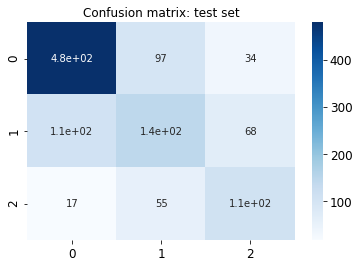

In [30]:
# Visualize the confusion matrix
ax = plt.subplot()
test_cf_matrix = confusion_matrix(test['y'], test_preds)
sns.heatmap(test_cf_matrix, annot = True, ax = ax, cmap = 'Blues')
plt.title('Confusion matrix: test set')
plt.show()

In [ ]:
# Save the results for later comparisons
eval_df = pd.DataFrame(columns = ['set', 'loss', 'accuracy'])
eval_df.loc[0] = ['test', 'hinge_loss', test_accuracy]
eval_df.to_csv(os.path.join(directory_name, 'eval_df_0.6.csv'))

### Predictions on Unlabeled Data

In [ ]:
# Load in additional sites that do not have predictions
pred = np.load(os.path.join(experiments_dir, 'x_pred.npy'))
pred.shape

(58, 224, 224, 3)

In [ ]:
x_pred_flattened = pred.reshape(pred.shape[0], -1)

In [ ]:
# Standardize the test set
x_mean_pred = pred.mean(axis = 0, keepdims = True)
x_std_pred = pred.std(axis = 0, keepdims = True) + 1e-7
x_pred = (pred - x_mean_pred) / x_std_pred
x_pred_flattened = x_pred.reshape(x_pred.shape[0], -1)
x_pred_flattened.shape

(58, 150528)

In [ ]:
collect()
del x_pred

In [ ]:
pred_preds = sgd_clf.predict(x_pred_flattened)

In [ ]:
pred_preds

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,
       0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0])

In [ ]:
len(pred_preds)

58

In [ ]:
# Save for further analysis
import pandas as pd 
pd.DataFrame(pred_preds).to_csv(os.path.join(experiments_dir, 'preds.csv'))